<div align="center">
<a href="https://vbti.nl"><img src="images/vbti_logo.png" width="400"></a>
</div>

# Recurrent Neural Networks
This notebook supports the 'Recurrent Neural Network' chapter of the [1-day masterclass "Deep Learning"](https://aiblog.nl/masterclass-deep-learning). It is not ment as a full course on deep learning, but rather gives you a flavor of the topic. For an in-depth AI training or consultancy please contact [VBTI](https://vbti.nl). 

Recurrent Neural Networks are a special type of artificial neural networks. They have feedback loops which give the network a memory function. This makes them ideal for handling time series data. During the masterclass the details of unrolling a network over time, vanishing gradients, Long Short Term Memory and Gated RNN's are explained. In this notebook you will build and train an RNN to forecast monthly milk production (pounds per cow).

<div align="center">
<a href="https://aiblog.nl/masterclass-deep-learning"><img src="images/rnn.png" width="400"></a>
</div>

In [1]:
# import some default libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
In this example we use a time series [dataset of monthly milk production per cow](https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line). The dataset consists of 168 months of data.

In [2]:
# import data using Pandas
url = 'https://raw.githubusercontent.com/breemen/masterclass-deep-learning/master/datasets/monthly-milk-production.csv'
dataframe = pd.read_csv(url)
dataframe.index = pd.date_range(start='1962-01', periods=len(dataframe), freq='M')
dataframe.drop(columns=['Month'], inplace=True)dataframe.head(10)


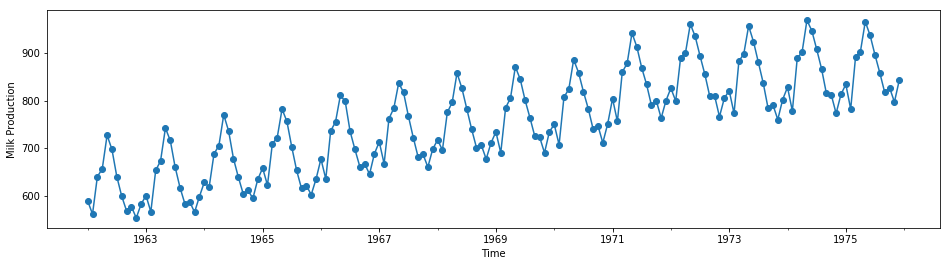

In [3]:
# plot data
plt.figure(figsize=(16,4))
dataframe['Milk Production'].plot(marker='o')
plt.xlabel('Time')
plt.ylabel('Milk Production');

In [4]:
# convert pandas dataframe to numpy array
data = dataframe.values.astype('float32')
data.shape

(168, 1)

In [5]:
# normalize the data between 0 and 1 for better RNN training
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [6]:
# create train and validation set
# the validation data consists of the last 40 samples
train_data, val_data = data[0:-40,:], data[-40:,:]

A RNN makes a prediction of the milk production at time t, based on the values at time t-1 to t-lookback. That is, it uses the last `lookback` number of samples to make a prediction. From `train_data` and `test_data` a dataset needs to be generated with the right number of lookback values per prediction.

In [7]:
lookback = 3 # use 3 months of data to predict next month

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

x_train, y_train = create_dataset(train_data, lookback)
x_val, y_val = create_dataset(val_data, lookback)

for i in range(10):
    print('{} -> {}'.format(x_train[i], y_train[i]))

[0.08653843 0.01923072 0.20913458] -> 0.2475961446762085
[0.01923072 0.20913458 0.24759614] -> 0.4182692766189575
[0.20913458 0.24759614 0.41826928] -> 0.3461538553237915
[0.24759614 0.41826928 0.34615386] -> 0.20913457870483398
[0.41826928 0.34615386 0.20913458] -> 0.11057686805725098
[0.34615386 0.20913458 0.11057687] -> 0.03605771064758301
[0.20913458 0.11057687 0.03605771] -> 0.05769228935241699
[0.11057687 0.03605771 0.05769229] -> 0.0
[0.03605771 0.05769229 0.        ] -> 0.06971156597137451
[0.05769229 0.         0.06971157] -> 0.11298072338104248


Finally, when data is passed to the RNN it should have the format (samples, time steps, features). Currently, our dataset has the form (samples, features). We need to reformat out data.

In [8]:
# reshape data to (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))

# Build neural network
A neural network can be build in two step. First the topology of the neural network is defined. This contains o.a. the number of layers, number of nodes (neurons) per layer and type of activation function. Next, a loss function and optimization function need to be defined. The [Keras](https://keras.io) framework is used for programming the neural network.

In [9]:
from keras import models
from keras import layers
from keras import optimizers

# define model topology
model = models.Sequential()
model.add(layers.LSTM(7, input_shape=(None, lookback)))
model.add(layers.Dense(1))

# define model optimization method
model.compile(optimizer=optimizers.Adam(lr=0.001), 
              loss='mean_squared_error')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7)                 308       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 316
Trainable params: 316
Non-trainable params: 0
_________________________________________________________________


# Train neural network

In [11]:
history = model.fit(x_train, y_train, epochs=20, batch_size=1, validation_data=(x_val, y_val))

Train on 124 samples, validate on 36 samples
Epoch 1/20
124/124 [==============================] - 2s 12ms/step - loss: 0.1259 - val_loss: 0.1704
Epoch 2/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0503
Epoch 3/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0268 - val_loss: 0.0378
Epoch 4/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0338
Epoch 5/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0286
Epoch 6/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0242
Epoch 7/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 8/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0242
Epoch 9/20
124/124 [==============================] - 0s 3ms/step - loss: 0.0183 - val_loss: 0.0202
Epoch 10/20
124/124 [==============================] -

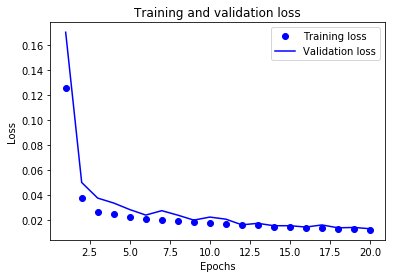

In [12]:
# plot training loss history
history_dict = history.history
loss_values  = history_dict['loss']
val_loss_values  = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# plot prediction
y_train_predict = model.predict(x_train)
y_val_predict = model.predict(x_val)

y_train_predict = scaler.inverse_transform(y_train_predict)
y_train = scaler.inverse_transform(y_train[:, np.newaxis])

y_val_predict = scaler.inverse_transform(y_val_predict)
y_val = scaler.inverse_transform(y_val[:, np.newaxis])

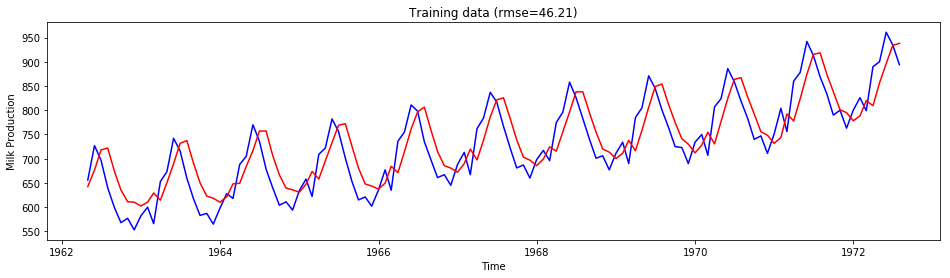

In [14]:
plt.figure(figsize=(16,4))
plt.plot(dataframe[lookback:lookback+y_train.shape[0]].index.values, y_train, 'b')
plt.plot(dataframe[lookback:lookback+y_train.shape[0]].index.values, y_train_predict, 'r')
plt.title('Training data (rmse={:.2f})'.format(np.sqrt(np.power(y_train - y_train_predict, 2).mean())))
plt.xlabel('Time')
plt.ylabel('Milk Production');

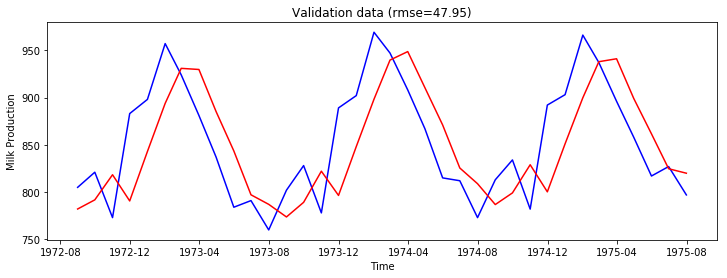

In [15]:
plt.figure(figsize=(12,4))
plt.plot(dataframe[lookback+y_train.shape[0]:lookback+y_train.shape[0]+y_val.shape[0]].index.values, y_val, 'b')
plt.plot(dataframe[lookback+y_train.shape[0]:lookback+y_train.shape[0]+y_val.shape[0]].index.values,y_val_predict, 'r')
plt.title('Validation data (rmse={:.2f})'.format(np.sqrt(np.power(y_val - y_val_predict, 2).mean())))
plt.xlabel('Time')
plt.ylabel('Milk Production');

# How to go further from here?
This notebook provides a basic processing pipeline for building a RNN that predicts monthly milk production. Experiment a little bit yourself by changing the number of layers, number of nodes per layer, number of epochs, number of lookback samples and learning rate. Try to reduce the root mean squared error (rmse).

## Hint
Feeding the model with more data from the past should increase its prediction accuracy.